In [1]:
from __future__ import absolute_import, division, print_function

import sys
import os
import time

sys.path.insert(0,'../../../')
sys.path.insert(0,'../../../py')

import parameters
import utilities
import spectrogram_utilities
import output_utilities
import spectrogram_output_visualiser
import spectrogram_cuts_db_creation

import numpy as np
import pandas as pd
import h5py

import tensorflow as tf
import keras
from scipy import signal
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# matplotlib.get_backend()
%matplotlib inline
#

In [2]:
# constants
awd_event = 1
site = parameters.sites[0]

## Database

### Loading H5 files

In [3]:
data, pb, evt, f_cut_length, t_cut_length = spectrogram_cuts_db_creation.load_spectrogram_cuts_db(awd_event, site, 'training_cuts.h5', verbose=True, noise=True)
# plt.figure(figsize=(8*3,8))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     k = np.random.randint(len(data))
#     plt.pcolormesh(data[k].reshape((f_cut_length,t_cut_length)), cmap='jet')
#     plt.xlabel(evt[k])
# plt.show()


Loading spectrogram cuts from database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 38.02 seconds


In [4]:
data = preprocessing.scale(data)

model = keras.Sequential([
#     keras.layers.Dense(1024, activation=tf.nn.relu),
#     keras.layers.Dense(512, activation=tf.nn.relu),
#     keras.layers.Dense(256, activation=tf.nn.relu),
#     keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
#     keras.layers.Dense(32, activation=tf.nn.relu),
#     keras.layers.Dense(16, activation=tf.nn.relu),
#     keras.layers.Dense(8, activation=tf.nn.relu),
#     keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(data, evt, batch_size=int(len(data)/100), epochs=5, shuffle=True)

Epoch 1/5
24028/24028 [==============================] - 4s 181us/step - loss: 0.1430 - acc: 0.9717
Epoch 2/5
24028/24028 [==============================] - 4s 174us/step - loss: 0.0195 - acc: 0.9970
Epoch 3/5
24028/24028 [==============================] - 4s 174us/step - loss: 0.0068 - acc: 0.9993
Epoch 4/5
24028/24028 [==============================] - 4s 174us/step - loss: 0.0058 - acc: 0.9995
Epoch 5/5
24028/24028 [==============================] - 4s 174us/step - loss: 0.0056 - acc: 0.9995


### Validation

In [5]:
# evaluate the model
training_loss, training_acc = model.evaluate(data, evt, verbose=0)

# 
data, pb, evt, f_cut_length, t_cut_length = spectrogram_cuts_db_creation.load_spectrogram_cuts_db(awd_event, site, 'validation_cuts.h5', verbose=True, noise=True)

validation_loss, validation_acc = model.evaluate(data, evt, verbose=0)

print('Training loss: %.3f, Validation loss: %.3f' % (training_loss, validation_loss))
print('Training acc: %.3f, Validation acc: %.3f' % (training_acc, validation_acc))


Loading spectrogram cuts from database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 16.43 seconds
Training loss: 0.006, Validation loss: 0.523
Training acc: 1.000, Validation acc: 0.652


KeyError: 'val_acc'

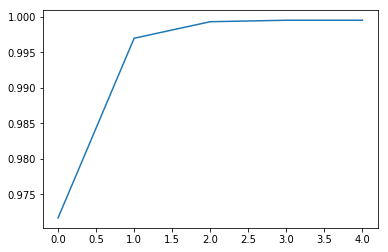

In [5]:
# learning curves of model accuracy
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

### Testing


Loading spectrogram cuts from database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 5.43 seconds
Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f6d962ddcf8>:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99      3504
        True       0.99      0.96      0.98      1575

   micro avg       0.99      0.99      0.99      5079
   macro avg       0.99      0.98      0.98      5079
weighted avg       0.99      0.99      0.99      5079


Confusion matrix:
[[3492   12]
 [  62 1513]]


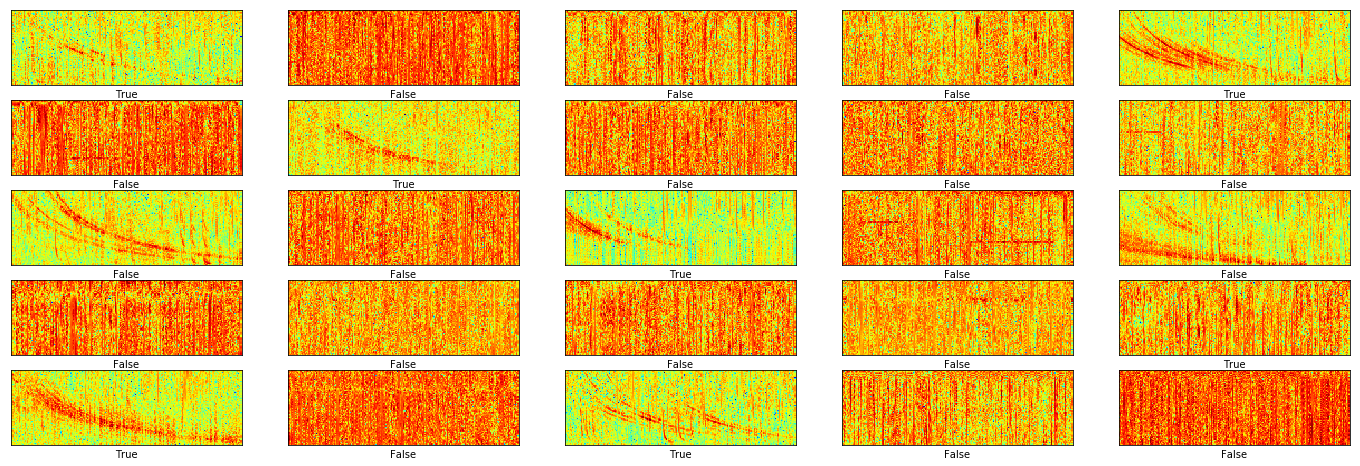

In [35]:
data, pb, evt, f_cut_length, t_cut_length = spectrogram_cuts_db_creation.load_spectrogram_cuts_db(awd_event, site, 'testing_cuts.h5', verbose=True, noise=True)

predictions = model.predict(data)
pred = np.argmax(predictions, axis=1)

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(evt, pred)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(evt, pred))

plt.figure(figsize=(8*3,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    k = np.random.randint(len(data))
    plt.pcolormesh(data[k].reshape((f_cut_length,t_cut_length)), cmap='jet')
    plt.xlabel(np.argmax(predictions[k]).astype(np.bool_))
plt.show()

In [9]:
from keras import models, layers, activations

model = models.Sequential()
# convolutional layer #1
model.add(layers.Conv2D(filters=8, 
                        kernel_size=[5,5], 
                        padding='same', 
                        activation=activations.relu))
# pooling layer #1
model.add(layers.MaxPooling2D(pool_size=(2, 2), 
                              strides=2, 
                              padding='same'))
# convolutional layer #1
model.add(layers.Conv2D(filters=16, 
                        kernel_size=[5,5], 
                        padding='same', 
                        activation=activations.relu))
# pooling layer #1
model.add(layers.MaxPooling2D(pool_size=(2, 2), 
                              strides=2, 
                              padding='same'))
# denser layer
model.add(layers.Flatten())
model.add(layers.Dense(units=1024, 
                activation=activations.relu))
model.add(layers.Dropout(rate=0.4))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])